In [1]:
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dotenv import dotenv_values
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 300)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
from data.preprocessing import DataPreprocessor
from config import get_connection
from data.db import execute_sql
from data.notifcation_preparation import *


In [2]:
conf = dotenv_values("../.env")

In [3]:
conn = get_connection(conf)

In [4]:
notifications = execute_sql(conn, "select * from notifications order by id")

In [5]:
notifications_list = flat_notifications_from_sql(notifications)

res = prepare_dataset(notifications_list)

In [6]:
res = DataPreprocessor.remove_partial_data(res)

In [104]:
raw = pd.DataFrame(data=res)
df = raw.reindex(sorted(raw.columns), axis=1)
df.shape

(79141, 726)

In [105]:
raw.columns

Index(['id', 'ticker', 'price', 'notification_date', 'highest_since_notified',
       'lowest_since_notified', 'filter_name', 'history_ticker',
       'history_modifiedAt', 'history_statsMap_-6_hours_time',
       ...
       'current_hour_bars_47_low', 'current_hour_bars_47_close',
       'current_hour_bars_47_volume', 'current_hour_bars_48_open',
       'current_hour_bars_48_high', 'current_hour_bars_48_low',
       'current_hour_bars_48_close', 'current_hour_bars_48_volume',
       'current_previouslyAccessed_24HoursBackMinute',
       'current_hourlyBarsTime'],
      dtype='object', length=726)

In [106]:
df = DataPreprocessor.remove_corrupt_data(df)
df.shape

(76218, 726)

In [107]:
datetime.fromisoformat("2022-07-02 11:17")

datetime.datetime(2022, 7, 2, 11, 17)

In [108]:
# remove semi missing data 2022-05-11 to 2022-05-24
df = DataPreprocessor.remove_date_range(df, 
                                        datetime.fromisoformat("2022-05-11"),
                                        datetime.fromisoformat("2022-05-24")
                                        )
df.shape

(76105, 726)

In [109]:
# remove semi missing data 2022-06-30 16:30 to 2022-07-02 11:17
df = DataPreprocessor.remove_date_range(df, 
                                        datetime.fromisoformat("2022-06-30 16:30"),
                                        datetime.fromisoformat("2022-07-02 11:17")
                                        )
df.shape

(75922, 726)

In [110]:
df = DataPreprocessor.remove_most_recent_data(df)
df.shape

(73758, 726)

In [111]:
df = DataPreprocessor.add_regression_label_columns(df)
df.shape

(73758, 728)

In [112]:
df = DataPreprocessor.drop_categorical_features(df)
df.shape

(73758, 693)

In [113]:
#df.select_dtypes(include=['object'])

In [114]:
df = df.drop_duplicates(keep='first')
df.shape

(49617, 693)

In [115]:
# COMMENTED OUT
# drop columns with duplicated values, leave first one
#df = df.loc[:,~df.apply(lambda y: y.duplicated(),axis=1).all()].copy()
#df.shape
df = DataPreprocessor.select_only_required_features(df)
df.shape

(49617, 661)

In [116]:
# Initial try, with filling df with 0
df = df.fillna(0)

In [117]:
# if volume is negative - replace with zero
DataPreprocessor.replace_negative_volumes(df)

In [118]:
DataPreprocessor.add_current_hour_volume(df)

In [119]:
history_vol_cols = DataPreprocessor.add_current_hour_volume_to_historical_volumes_coef(df)

In [120]:
next(history_vol_cols)

['history_statsMap_-10_days_avg1HourVolume', 'history_statsMap_-12_hours_avg1HourVolume', 'history_statsMap_-14_days_avg1HourVolume', 'history_statsMap_-20_days_avg1HourVolume', 'history_statsMap_-24_hours_avg1HourVolume', 'history_statsMap_-28_days_avg1HourVolume', 'history_statsMap_-3_days_avg1HourVolume', 'history_statsMap_-5_days_avg1HourVolume', 'history_statsMap_-6_hours_avg1HourVolume', 'history_statsMap_-7_days_avg1HourVolume']


['current_h_vol_to_10_days_avg',
 'current_h_vol_to_12_hours_avg',
 'current_h_vol_to_14_days_avg',
 'current_h_vol_to_20_days_avg',
 'current_h_vol_to_24_hours_avg',
 'current_h_vol_to_28_days_avg',
 'current_h_vol_to_3_days_avg',
 'current_h_vol_to_5_days_avg',
 'current_h_vol_to_6_hours_avg',
 'current_h_vol_to_7_days_avg']

In [121]:
# finding corrupt data with excessive volumes, requires categorical features
#df[(df["id"] > 13000) & (df["id"] < 17000)].loc[::, ["id", "notification_date", *next(history_vol_cols)]].nlargest(n=3000, columns=['current_h_vol_to_28_days_avg'], keep='all')

In [122]:
# Which signal made best return?
df[df['label_up_return'] == df['label_up_return'].max()]

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_close,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-10_days_low,btc_stats_statsMap_-10_days_open,btc_stats_statsMap_-12_hours_avg1HourVolume,btc_stats_statsMap_-12_hours_changeRate,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-12_hours_low,btc_stats_statsMap_-12_hours_open,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_changeRate,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-14_days_low,btc_stats_statsMap_-14_days_open,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-20_days_low,btc_stats_statsMap_-20_days_open,btc_stats_statsMap_-24_hours_avg1HourVolume,btc_stats_statsMap_-24_hours_changeRate,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-24_hours_low,btc_stats_statsMap_-24_hours_open,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-28_days_low,btc_stats_statsMap_-28_days_open,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-3_days_low,btc_stats_statsMap_-3_days_open,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-5_days_low,btc_stats_statsMap_-5_days_open,btc_stats_statsMap_-60_days_avg1HourVolume,btc_stats_statsMap_-60_days_changeRate,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-60_days_low,btc_stats_statsMap_-60_days_open,btc_stats_statsMap_-6_hours_avg1HourVolume,btc_stats_statsMap_-6_hours_changeRate,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-6_hours_low,btc_stats_statsMap_-6_hours_open,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_high,btc_stats_statsMap_-7_days_low,btc_stats_statsMap_-7_days_open,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_01_high,current_hour_bars_01_low,current_hour_bars_01_open,current_hour_bars_01_volume,current_hour_bars_02_close,current_hour_bars_02_high,current_hour_bars_02_low,current_hour_bars_02_open,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_high,current_hour_bars_03_low,current_hour_bars_03_open,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_high,current_hour_bars_04_low,current_hour_bars_04_open,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_high,current_hour_bars_05_low,current_hour_bars_05_open,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_high,current_hour_bars_06_low,current_hour_bars_06_open,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_high,current_hour_bars_07_low,current_hour_bars_07_open,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_high,current_hour_bars_08_low,current_hour_bars_08_open,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_high,current_hour_bars_09_low,current_hour_bars_09_open,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_high,current_hour_bars_10_low,current_hour_bars_10_open,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_high,current_hour_bars_11_low,current_hour_bars_11_open,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_high,current_hour_bars_12_low,current_hour_bars_12_open,current_hour_bars_12_volume,current_hour_bars_13_close,current_hour_bars_13_high,current_hour_bars_13_low,current_hour_bars_13_open,current_hour_bars_13_volume,current_hour_bars_14_close,current_hour_bars_14_high,current_hour_bars_14_low,current_hour_bars_14_open,current_hour_bars_14_volume,current_hour_bars_15_close,cur

In [123]:
# Which signal made worst return?
df[df['label_down_return'] == df['label_down_return'].min()]

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_close,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-10_days_low,btc_stats_statsMap_-10_days_open,btc_stats_statsMap_-12_hours_avg1HourVolume,btc_stats_statsMap_-12_hours_changeRate,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-12_hours_low,btc_stats_statsMap_-12_hours_open,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_changeRate,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-14_days_low,btc_stats_statsMap_-14_days_open,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-20_days_low,btc_stats_statsMap_-20_days_open,btc_stats_statsMap_-24_hours_avg1HourVolume,btc_stats_statsMap_-24_hours_changeRate,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-24_hours_low,btc_stats_statsMap_-24_hours_open,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-28_days_low,btc_stats_statsMap_-28_days_open,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-3_days_low,btc_stats_statsMap_-3_days_open,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-5_days_low,btc_stats_statsMap_-5_days_open,btc_stats_statsMap_-60_days_avg1HourVolume,btc_stats_statsMap_-60_days_changeRate,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-60_days_low,btc_stats_statsMap_-60_days_open,btc_stats_statsMap_-6_hours_avg1HourVolume,btc_stats_statsMap_-6_hours_changeRate,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-6_hours_low,btc_stats_statsMap_-6_hours_open,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_high,btc_stats_statsMap_-7_days_low,btc_stats_statsMap_-7_days_open,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_01_high,current_hour_bars_01_low,current_hour_bars_01_open,current_hour_bars_01_volume,current_hour_bars_02_close,current_hour_bars_02_high,current_hour_bars_02_low,current_hour_bars_02_open,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_high,current_hour_bars_03_low,current_hour_bars_03_open,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_high,current_hour_bars_04_low,current_hour_bars_04_open,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_high,current_hour_bars_05_low,current_hour_bars_05_open,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_high,current_hour_bars_06_low,current_hour_bars_06_open,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_high,current_hour_bars_07_low,current_hour_bars_07_open,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_high,current_hour_bars_08_low,current_hour_bars_08_open,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_high,current_hour_bars_09_low,current_hour_bars_09_open,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_high,current_hour_bars_10_low,current_hour_bars_10_open,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_high,current_hour_bars_11_low,current_hour_bars_11_open,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_high,current_hour_bars_12_low,current_hour_bars_12_open,current_hour_bars_12_volume,current_hour_bars_13_close,current_hour_bars_13_high,current_hour_bars_13_low,current_hour_bars_13_open,current_hour_bars_13_volume,current_hour_bars_14_close,current_hour_bars_14_high,current_hour_bars_14_low,current_hour_bars_14_open,current_hour_bars_14_volume,current_hour_bars_15_close,cur

In [124]:
df_vol = df[[*next(history_vol_cols), 'label_up_return', 'label_down_return']]
x = df_vol.drop(['label_up_return','label_down_return'], 1)

from scipy import stats
# cleaning outliers in data
df_vol_coef_clean = df_vol[((x > x.quantile(.03)) & (x < x.quantile(.97))).all(1)]
#df_vol_coef_clean = df_vol[(np.abs(stats.zscore(df_vol)) < 4).all(axis=1)]
df_vol_coef_clean.shape

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20360\716218441.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = df_vol.drop(['label_up_return','label_down_return'], 1)


(43071, 12)

<AxesSubplot:>

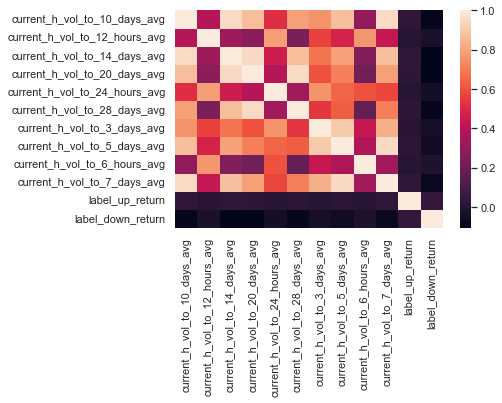

In [125]:
sns.heatmap(df_vol_coef_clean.corr())

In [126]:
df = next(DataPreprocessor.remove_outliers(df, history_vol_cols))
df.shape

D:\Projects\trading-bot-ml\src\data\preprocessing.py:201: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = df_vol.drop(['label_up_return', 'label_down_return'], 1)


(47589, 672)

In [127]:
# removing those which don't have -3 hours of data
df = DataPreprocessor.remove_rows_with_less_than_3_hours(df)
df.shape

(45796, 672)

In [128]:
df['price']

0        0.385000
1        0.289600
4        0.052950
5        0.053000
6        0.000747
           ...   
76964    0.002484
76965    0.254000
76969    0.000796
76970    0.002406
76972    0.020600
Name: price, Length: 45796, dtype: float64

<AxesSubplot:>

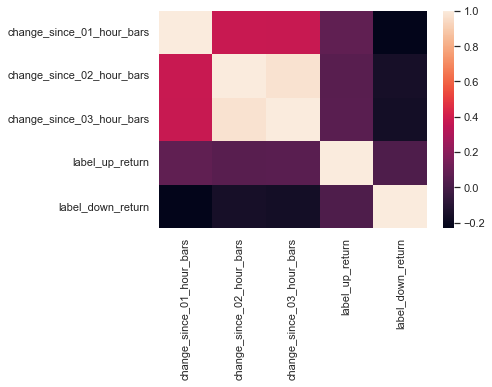

In [129]:
latest_close_cols = ['change_since_01_hour_bars', 'change_since_02_hour_bars', 'change_since_03_hour_bars']
df['change_since_01_hour_bars'] = (df['price'] - df['current_hour_bars_01_close']) / df['current_hour_bars_01_close'] * 100
df['change_since_02_hour_bars'] = (df['price'] - df['current_hour_bars_02_close']) / df['current_hour_bars_02_close'] * 100
df['change_since_03_hour_bars'] = (df['price'] - df['current_hour_bars_03_close']) / df['current_hour_bars_03_close'] * 100
df_change_since_previous = df[[*latest_close_cols, 'label_up_return', 'label_down_return']]
sns.heatmap(df_change_since_previous.corr())

C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='change_since_01_hour_bars', ylabel='label_down_return'>

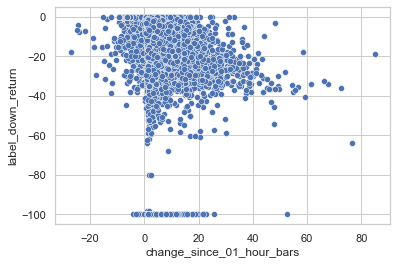

In [130]:
# there is some reverse correlation in change and down return
sns.scatterplot(df['change_since_01_hour_bars'], df['label_down_return'])

<AxesSubplot:>

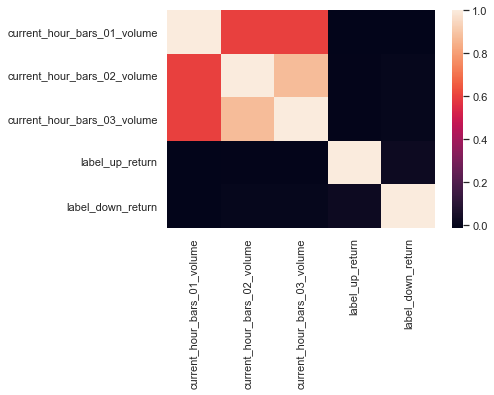

In [131]:
df_volume_on_previous = df[['current_hour_bars_01_volume',
    'current_hour_bars_02_volume',
    'current_hour_bars_03_volume',
    'label_up_return', 'label_down_return']]
sns.heatmap(df_volume_on_previous.corr())

<AxesSubplot:>

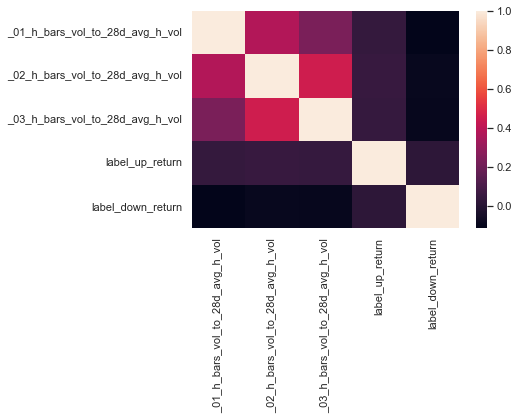

In [132]:
df['_01_h_bars_vol_to_28d_avg_h_vol'] = df['current_hour_bars_01_volume'] / df['history_statsMap_-28_days_avg1HourVolume']
df['_02_h_bars_vol_to_28d_avg_h_vol'] = df['current_hour_bars_02_volume'] / df['history_statsMap_-28_days_avg1HourVolume']
df['_03_h_bars_vol_to_28d_avg_h_vol'] = df['current_hour_bars_03_volume'] / df['history_statsMap_-28_days_avg1HourVolume']
df_volume_on_previous_as_coef = df[['_01_h_bars_vol_to_28d_avg_h_vol',
    '_02_h_bars_vol_to_28d_avg_h_vol',
    '_03_h_bars_vol_to_28d_avg_h_vol',
    'label_up_return', 'label_down_return']]
sns.heatmap(df_volume_on_previous_as_coef.corr())

<AxesSubplot:>

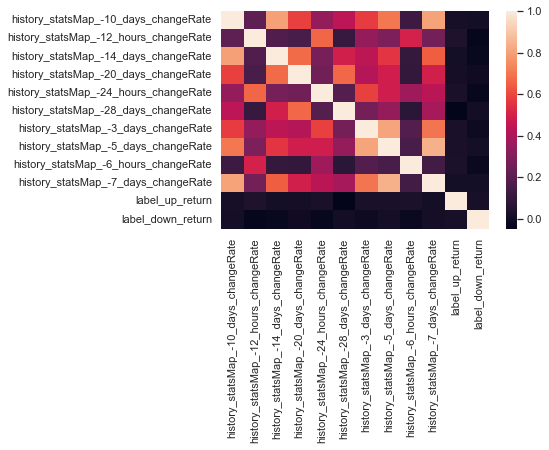

In [133]:
history_change_rate_cols = [c for c in df.columns if str(c).startswith('history_statsMap_-') and str(c).endswith('changeRate')]
df_history_change_rate = df[[*history_change_rate_cols, 'label_up_return', 'label_down_return']]
sns.heatmap(df_history_change_rate.corr())

In [134]:
df_vol_coef_clean[df_vol_coef_clean['current_h_vol_to_5_days_avg'] == df_vol_coef_clean['current_h_vol_to_5_days_avg'].max()]

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
40073,13.558628,7.871385,13.171407,13.500772,8.928842,13.97623,13.576261,19.645099,8.9674,16.567924,11.191084,-8.319789


In [135]:
with_cut = df
with_cut['up_return'] = pd.cut(df['label_up_return'], 
                               bins=[0, 10, 20, 30, 40, 50, 70, 100, 300, float('Inf')], 
                               labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-70', '70-100', '100-300', '300+'])

In [136]:
with_cut['down_return'] = pd.cut(df['label_down_return'],
                                 bins=[float('-Inf'), -30, -20, -10, 0], 
                                 labels=['-30', '-30-20', '-20-10', '-10-0'])

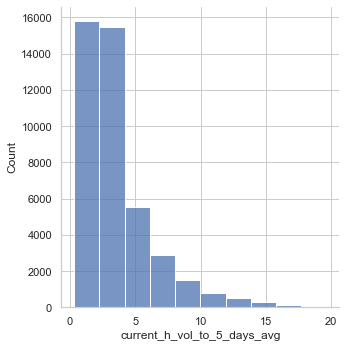

In [137]:
sns.displot(df_vol_coef_clean, x='current_h_vol_to_5_days_avg', bins=10)

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_01_volume'>

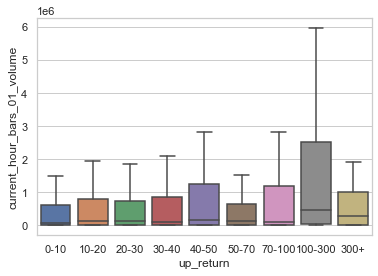

In [138]:
sns.boxplot(x = 'up_return', y = 'current_hour_bars_01_volume', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_02_volume'>

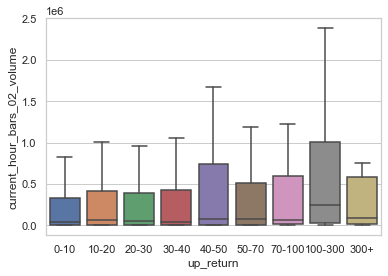

In [139]:
sns.boxplot(x = 'up_return', y = 'current_hour_bars_02_volume', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_03_volume'>

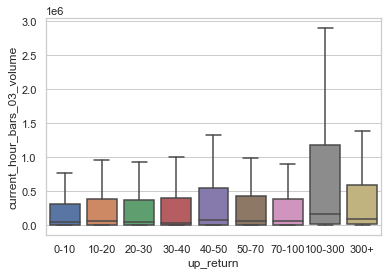

In [140]:
sns.boxplot(x = 'up_return', y = 'current_hour_bars_03_volume', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='change_since_01_hour_bars'>

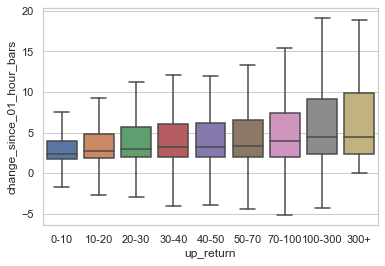

In [141]:
sns.boxplot(x = 'up_return', y = 'change_since_01_hour_bars', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='change_since_02_hour_bars'>

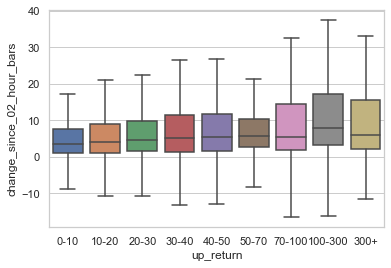

In [142]:
sns.boxplot(x = 'up_return', y = 'change_since_02_hour_bars', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='change_since_03_hour_bars'>

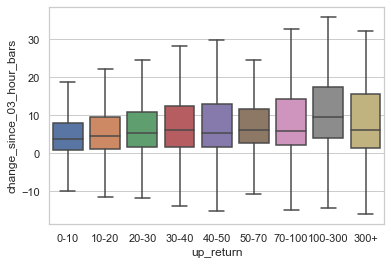

In [143]:
sns.boxplot(x = 'up_return', y = 'change_since_03_hour_bars', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='change_since_01_hour_bars'>

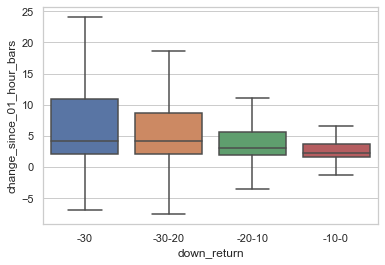

In [144]:
sns.boxplot(x = 'down_return', y = 'change_since_01_hour_bars', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='change_since_02_hour_bars'>

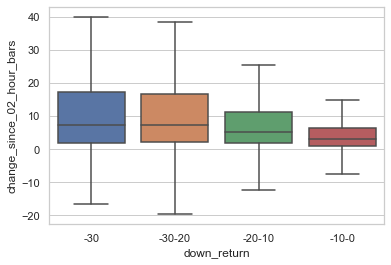

In [145]:
sns.boxplot(x = 'down_return', y = 'change_since_02_hour_bars', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='change_since_03_hour_bars'>

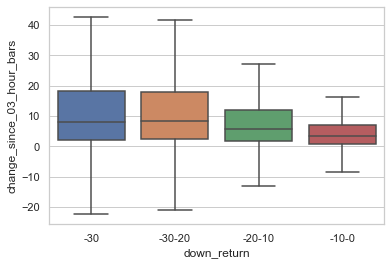

In [146]:
sns.boxplot(x = 'down_return', y = 'change_since_03_hour_bars', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_h_vol_to_5_days_avg'>

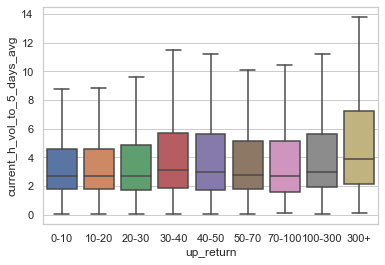

In [147]:
sns.boxplot(x = 'up_return', y = 'current_h_vol_to_5_days_avg', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_h_vol_to_14_days_avg'>

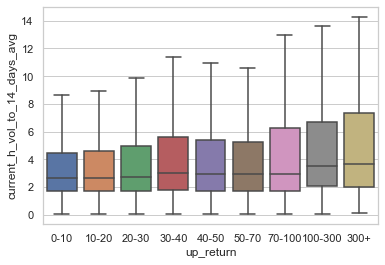

In [148]:
sns.boxplot(x = 'up_return', y = 'current_h_vol_to_14_days_avg', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_h_vol_to_28_days_avg'>

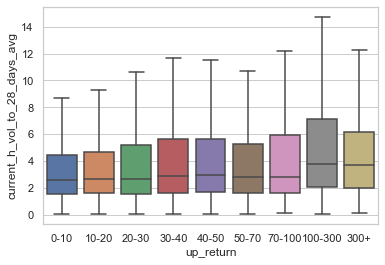

In [149]:
sns.boxplot(x = 'up_return', y = 'current_h_vol_to_28_days_avg', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='current_h_vol_to_5_days_avg'>

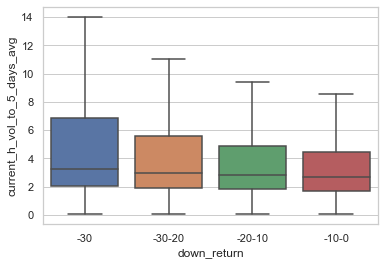

In [150]:
sns.boxplot(x = 'down_return', y = 'current_h_vol_to_5_days_avg', data = with_cut, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='current_h_vol_to_28_days_avg'>

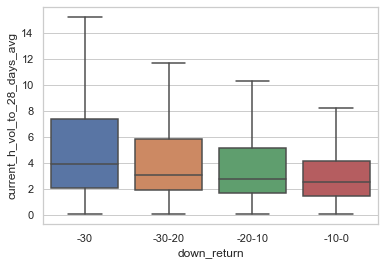

In [151]:
sns.boxplot(x = 'down_return', y = 'current_h_vol_to_28_days_avg', data = with_cut, showfliers = False) 

In [152]:
df_vol_coef_clean.nlargest(n=50, columns=['current_h_vol_to_5_days_avg'], keep='all')

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
40073,13.558628,7.871385,13.171407,13.500772,8.928842,13.976230,13.576261,19.645099,8.967400,16.567924,11.191084,-8.319789
76079,5.633282,9.920035,6.693027,7.667721,10.517173,7.384652,17.637539,19.510819,7.383754,15.090349,5.941333,-0.442667
20482,10.978488,10.198942,13.723110,10.563820,10.400597,10.743860,16.065809,19.420381,8.763169,18.101495,13.156585,-26.661688
5577,8.364060,9.324707,7.844781,6.133925,11.349415,6.036338,17.579160,19.398940,5.522212,17.649363,0.060569,-10.006057
4209,10.603467,5.192093,9.987106,8.557082,8.672678,8.258863,14.861795,19.386866,3.330475,13.646284,9.674094,-14.368409
58748,13.434936,18.979669,15.999782,14.601713,9.137890,16.363410,15.688716,19.378627,29.235720,15.622226,66.156463,-5.612245
39625,18.457127,8.132122,16.615638,14.797713,9.877111,11.537236,18.094886,19.375832,8.794094,18.336579,5.049077,-8.190027
2026,10.520691,16.686636,9.451505,10.360716,20.740015,9.140865,19.472039,19.224461,20.679651,14.367929,0.794456,-9.005005
76068,5.550521,9.774295,6.594696,7.555070,10.362659,7.276160,17.378416,19.224175,7.275275,14.868648,6.737166,0.000000
9896,11.204511,12.357812,9.128910,7.374488,14.183406,3.130939,16.387420,19.188456,10.456255,14.688380,0.000000,-9.659091


In [153]:
# 10 largest by up return
df_vol_coef_clean.nlargest(n=10, columns=['label_up_return'], keep='all')

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
73495,7.453332,1.240363,4.084024,2.019651,2.211787,1.457357,4.593917,6.404197,0.861156,7.242440,3251.139410,-1.407507
73576,4.216829,0.701753,2.310595,1.142646,1.251350,0.824521,2.599075,3.623266,0.487211,4.097514,3251.139410,-1.407507
73670,7.537911,1.254439,4.130368,2.042569,2.236886,1.473895,4.646048,6.476870,0.870928,7.324626,3251.139410,-1.407507
73692,8.487704,1.412501,4.650804,2.299938,2.518739,1.659609,5.231461,7.292970,0.980667,8.247545,3248.894843,-1.473543
76224,4.100196,0.677962,3.143479,1.562958,0.720080,1.119008,1.804208,2.752236,0.686051,3.366216,2965.542612,-4.291845
76249,5.227816,0.864412,4.007987,1.992796,0.918114,1.426753,2.300394,3.509145,0.874727,4.291979,2791.787160,-9.716599
34146,1.033744,1.245787,0.944381,0.893172,1.344279,1.012714,1.056664,0.908081,1.274076,0.992868,2006.339468,-2.862986
50204,3.326463,10.183598,3.121300,3.221921,7.671403,3.145553,6.495036,4.618000,12.578460,3.664019,1663.433275,-6.937096
50131,1.896753,5.806699,1.779768,1.837143,4.374242,1.793598,3.703476,2.633188,7.172251,2.089228,1530.217391,-15.760870
50134,2.500459,7.654879,2.346240,2.421877,5.766494,2.364471,4.882234,3.471290,9.455065,2.754196,1479.568194,-18.378094


In [154]:
# 10 smallest by down return
df_vol_coef_clean.nsmallest(n=10, columns=['label_down_return'], keep='all')

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
70777,0.582328,8.024395,0.664462,0.779781,4.159627,0.558615,0.556936,0.638137,7.878260,0.709666,21.843778,-100.0
70778,3.138495,1.659433,4.006979,5.056008,1.530810,6.449707,1.348437,1.632146,1.836377,2.252542,0.749064,-100.0
70799,0.602987,8.309069,0.688034,0.807444,4.307194,0.578432,0.576693,0.660775,8.157749,0.734842,19.937416,-100.0
70802,0.977542,13.470390,1.115419,1.309002,6.982681,0.937735,0.934917,1.071228,13.225076,1.191302,19.350534,-100.0
70804,1.137861,15.679558,1.298350,1.523681,8.127854,1.091525,1.088245,1.246911,15.394012,1.386678,17.417943,-100.0
70811,0.633232,8.725849,0.722546,0.847945,4.523241,0.607446,0.605620,0.693920,8.566940,0.771702,17.623849,-100.0
70821,5.945944,15.834432,5.071413,4.044301,15.418051,2.945405,7.444294,8.199404,12.511187,7.737932,16.502034,-100.0
70823,7.993767,21.287916,6.818042,5.437185,20.728131,3.959822,10.008159,11.023334,16.820123,10.402927,14.833906,-100.0
70857,3.919414,3.728260,3.933962,2.423942,2.297128,1.720763,5.035417,4.556310,5.125958,3.826861,13.481675,-100.0
70864,6.325685,6.017174,6.349164,3.912088,3.707418,2.777202,8.126841,7.353593,8.272970,6.176310,12.597403,-100.0


In [155]:
# for c in  history_vol_cols:
#     sns.displot(df_vol_coef_clean[c], stat = 'density', binwidth=3)

In [156]:
list(df.columns)

['btc_stats_statsMap_-10_days_avg1HourVolume',
 'btc_stats_statsMap_-10_days_changeRate',
 'btc_stats_statsMap_-10_days_close',
 'btc_stats_statsMap_-10_days_high',
 'btc_stats_statsMap_-10_days_low',
 'btc_stats_statsMap_-10_days_open',
 'btc_stats_statsMap_-12_hours_avg1HourVolume',
 'btc_stats_statsMap_-12_hours_changeRate',
 'btc_stats_statsMap_-12_hours_high',
 'btc_stats_statsMap_-12_hours_low',
 'btc_stats_statsMap_-12_hours_open',
 'btc_stats_statsMap_-14_days_avg1HourVolume',
 'btc_stats_statsMap_-14_days_changeRate',
 'btc_stats_statsMap_-14_days_high',
 'btc_stats_statsMap_-14_days_low',
 'btc_stats_statsMap_-14_days_open',
 'btc_stats_statsMap_-20_days_avg1HourVolume',
 'btc_stats_statsMap_-20_days_changeRate',
 'btc_stats_statsMap_-20_days_high',
 'btc_stats_statsMap_-20_days_low',
 'btc_stats_statsMap_-20_days_open',
 'btc_stats_statsMap_-24_hours_avg1HourVolume',
 'btc_stats_statsMap_-24_hours_changeRate',
 'btc_stats_statsMap_-24_hours_high',
 'btc_stats_statsMap_-24_ho

In [157]:
from data.scalers import min_max_scaler, standard_scaler


In [158]:
df = df.drop(['up_return', 'down_return'], axis=1)
df_norm = min_max_scaler(df)
df_std= standard_scaler(df)
##%%
#corr = df.corr()['label_up_return']
##%%
#pd.set_option('display.max_rows', None)  # or 1000
#abs(corr).sort_values(ascending=False)
##%%
#pd.set_option('display.max_rows', 10)  # or 1000

In [159]:
label_cols = ['label_up_return', 'label_down_return']
x = df.drop(label_cols, axis=1)
y_up = df['label_up_return']
y_down = df['label_down_return']

x_norm = df_norm.drop(label_cols, axis=1)
y_up_norm = df_norm['label_up_return']
y_down_norm = df_norm['label_down_return']

x_std = df_std.drop(label_cols, axis=1)
y_up_std = df_std['label_up_return']
y_down_std = df_std['label_down_return']

In [160]:
# EDA using SWEETVIZ automl library
#import sweetviz as sv
#sv_report = sv.analyze(df, pairwise_analysis='off')
#sv_report.show_html("sv.html")

In [179]:
from model_factory import ModelFactory
_, y_up_class = ModelFactory.prepare_classification_label(df, 20)
y_up_class.value_counts()

KeyError: 'label_up_return'

In [ ]:
y_down_class = ModelFactory.prepare_classification_label(df, -10)
y_down_class.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_random_forest_clasifier(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train)
    return x_train, x_test, y_train, y_test, rfc

In [ ]:
def train_logistic_regression_clasifier(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    from sklearn.linear_model import LogisticRegression
    rfc = LogisticRegression(max_iter=5000, penalty="l2")
    rfc.fit(x_train, y_train)
    return x_train, x_test, y_train, y_test, rfc

In [ ]:
x_up_class, x_up_test_class, y_train_up_class, y_up_test_class, up_random_forest_model = train_random_forest_clasifier(x, y_up_class)

In [ ]:
def eval_model(x_up_class, x_up_test_class, y_up_class, y_up_test_class, up_random_forest_model):
    # Make predictions for the test UP set
    y_up_predictions = up_random_forest_model.predict(x_up_test_class)
    # View accuracy score
    print(accuracy_score(y_up_test_class, y_up_predictions))
    
    # View confusion matrix for test data and predictions
    matrix = confusion_matrix(y_up_test_class, y_up_predictions)
    print(matrix)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    
    # Add labels to the plot
    class_names = ['Higher than 20%', 'Lower Than 20%']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Random Forest Model')
    plt.show()
    # View the classification report for test data and predictions
    print(classification_report(y_up_test_class, y_up_predictions))
    

0.9405049396267837
[[3814   30]
 [ 241  470]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3844
           1       0.94      0.66      0.78       711

    accuracy                           0.94      4555
   macro avg       0.94      0.83      0.87      4555
weighted avg       0.94      0.94      0.94      4555



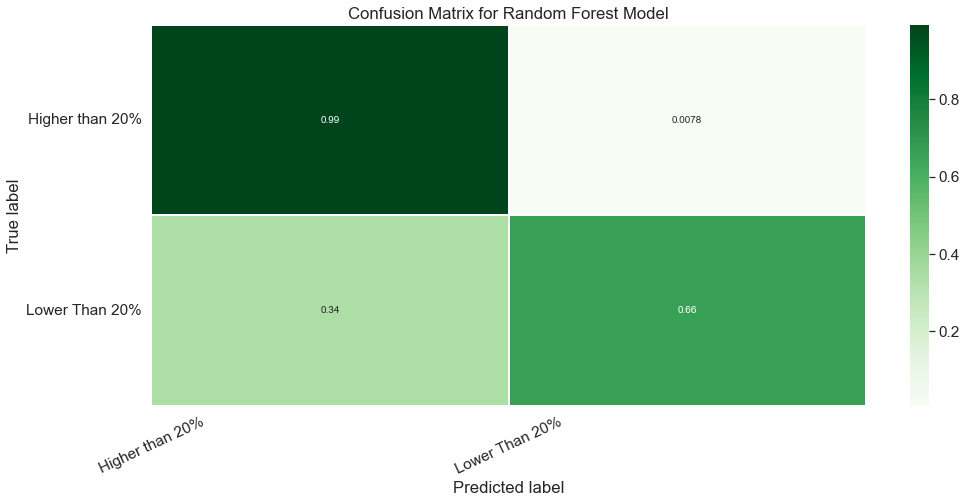

In [162]:
eval_model(x_up_class, x_up_test_class, y_train_up_class, y_up_test_class, up_random_forest_model)

In [163]:
eval_model(*train_logistic_regression_clasifier(x_std, y_up_class))

ValueError: Found input variables with inconsistent numbers of samples: [45796, 2]

In [164]:
x_down_class, x_down_test_class, y_down_train_class, y_down_test_class, down_random_forest_model = train_random_forest_clasifier(x, y_down_class)

ValueError: Found input variables with inconsistent numbers of samples: [45796, 45542]

In [165]:
# Make predictions for the test DOWN set
y_down_predictions = down_random_forest_model.predict(x_down_test_class)
# View accuracy score
accuracy_score(y_down_test_class, y_down_predictions)

0.887596048298573

In [166]:
# View confusion matrix for test data and predictions
matrix = confusion_matrix(y_down_test_class, y_down_predictions)
matrix

array([[1678,  290],
       [ 222, 2365]], dtype=int64)

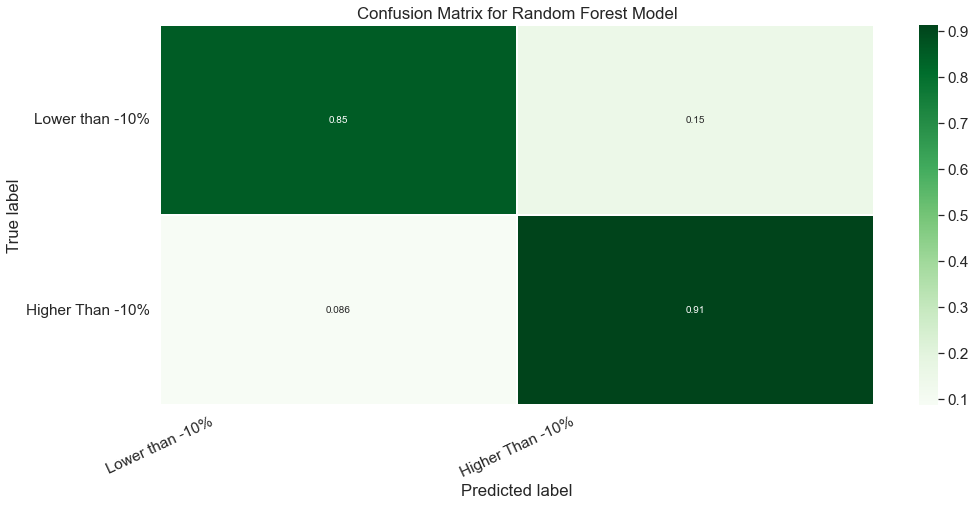

In [167]:
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Lower than -10%', 'Higher Than -10%']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [168]:
# View the classification report for test data and predictions
print(classification_report(y_down_test_class, y_down_predictions))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1968
           1       0.89      0.91      0.90      2587

    accuracy                           0.89      4555
   macro avg       0.89      0.88      0.88      4555
weighted avg       0.89      0.89      0.89      4555



In [169]:
# check stats using OLS from statsmodels
#import statsmodels.api as sm
#results = sm.OLS(y_up,x).fit()
#results.summary()